In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Reshape, LSTM, Input, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import seaborn as sns
from collections import Counter
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19   # Pre-trained models for transfer learning

In [22]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 3

## Image Processing

In [24]:
# Fungsi Deteksi Objek Menggunakan YOLOv5
def detect_objects_yolo(image_path, model_path='yolov5s'):
    model = torch.hub.load('ultralytics/yolov5', model_path)
    results = model(image_path)
    detections = results.xyxy[0] 
    detections = detections.cpu().numpy()
    return detections, results

In [26]:
# Fungsi untuk memproses gambar dengan deteksi objek
def preprocess_with_detection_and_processing(image_path, target_size=(64, 64)):
    # Deteksi objek
    detections, _ = detect_objects_yolo(image_path)
    
    img = cv2.imread(image_path)
    
    if len(detections) > 0:
        # Pilih deteksi dengan confidence tertinggi
        x_min, y_min, x_max, y_max, _, _ = detections[0]
        img = img[int(y_min):int(y_max), int(x_min):int(x_max)]
    
    # Resize ke ukuran target
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    
    # Image Processing: Edge Detection dan Sharpening
    kernel_edge = np.array([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]])
    edges = cv2.filter2D(img, -1, kernel_edge)
    
    kernel_sharpen = np.array([[0, -1, 0],
                               [-1,  5, -1],
                               [0, -1, 0]])
    processed_img = cv2.filter2D(edges, -1, kernel_sharpen)
    
    return processed_img

### Augmentasi Data dan Normalisasi data

In [28]:
# Custom ImageDataGenerator dengan Preprocessing
class CustomImageDataGeneratorWithProcessing(ImageDataGenerator):
    def preprocessing_function(self, img_path):
        return preprocess_with_detection_and_processing(img_path, target_size=IMG_SIZE)

In [30]:
# Data Generators
train_datagen = CustomImageDataGeneratorWithProcessing(
    rescale=1.0 / 255.0,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4]
)

validation_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)
test_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)

In [32]:
# Directories (Adjust paths as needed)
train_dir = 'dataset/train/'
val_dir = 'dataset/valid/'
test_dir = 'dataset/test/'

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Update NUM_CLASSES based on data
NUM_CLASSES = train_generator.num_classes
labels = train_generator.class_indices.keys()


Found 2721 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [34]:
labels

dict_keys(['mujahir', 'red_devil', 'sepat'])

## Visualisasi Data

Visualisasi data dengan train:


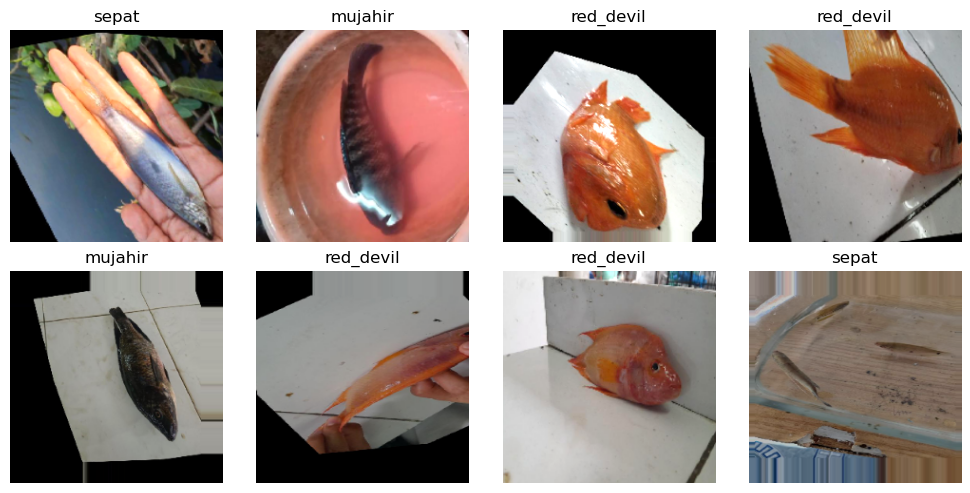

In [36]:
def plot_augmented_images(generator, labels, num_images=8):
    images, labels_batch = next(generator)

    num_images = min(num_images, len(images))  
    labels_decoded = [list(labels)[np.argmax(label)] for label in labels_batch[:num_images]]
    cols = 4  
    rows = (num_images + cols - 1) // cols  
    plt.figure(figsize=(cols * 2.5, rows * 2.5)) 

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(labels_decoded[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Visualisasi data dengan train:")
plot_augmented_images(train_generator, labels)


## GRID GAMBAR Dari Setiap Kelas

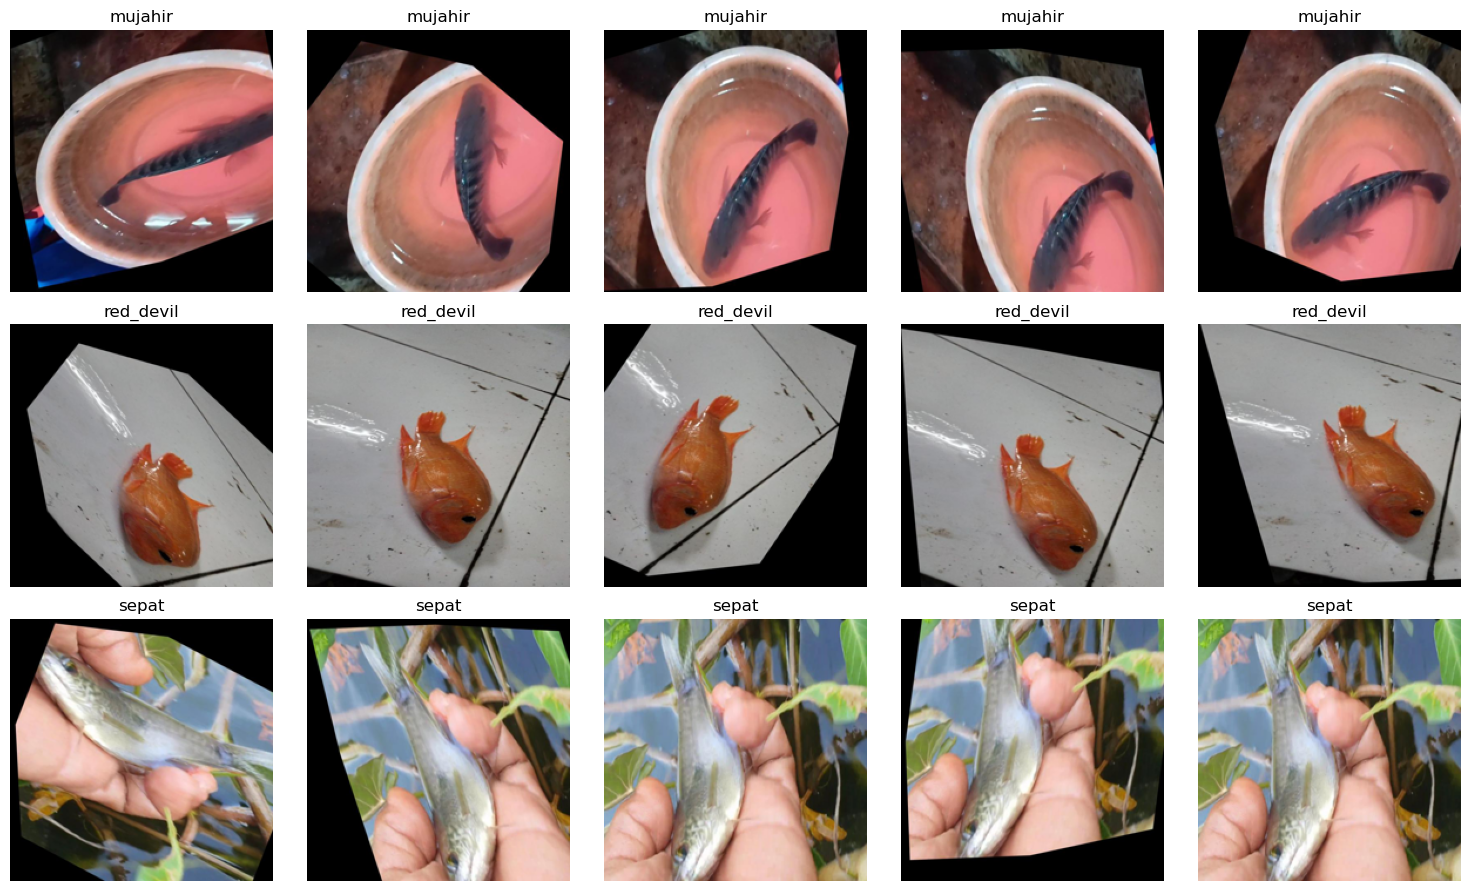

In [37]:
import os
from PIL import Image  
import matplotlib.pyplot as plt

def visualize_samples_per_class(directory, target_size, samples_per_class=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(target_size) 
            
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_samples_per_class(train_dir, target_size=IMG_SIZE, samples_per_class=5)


C:\Users\User\AppData\Local\Temp\ipykernel_14916\3841989112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


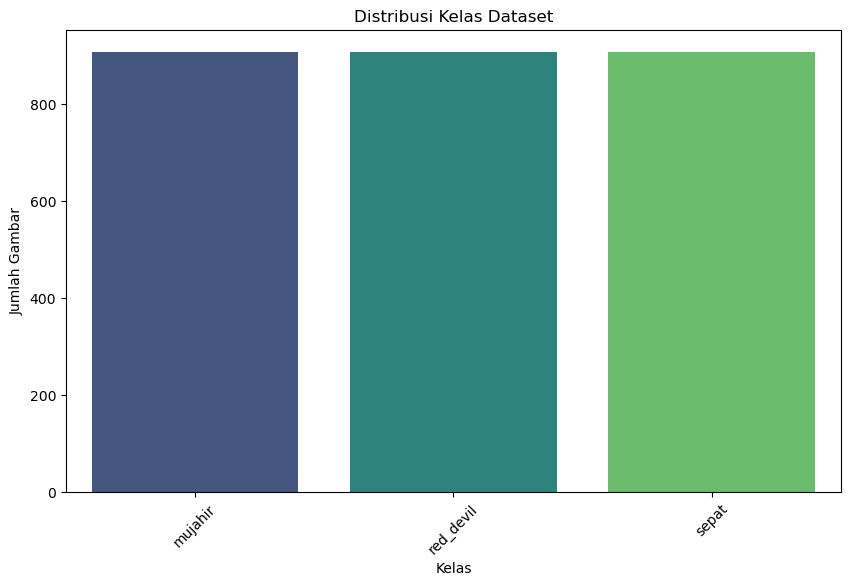

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
import numpy as np

def plot_class_distribution(generator):
    """Visualisasi distribusi kelas"""
    class_counts = Counter(generator.classes) 
    class_names = list(generator.class_indices.keys())
    counts = [class_counts[i] for i in range(len(class_names))]  
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.title("Distribusi Kelas Dataset")
    plt.ylabel("Jumlah Gambar")
    plt.xlabel("Kelas")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator)


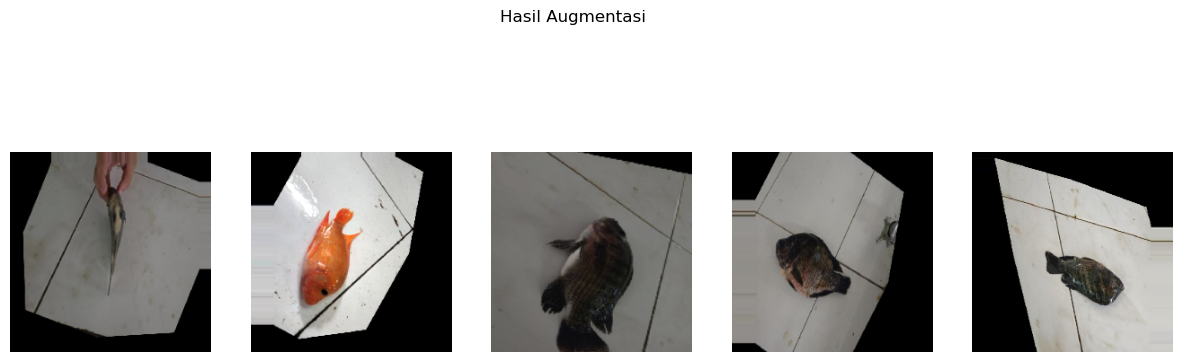

In [39]:
def visualize_augmentation(generator, num_images=5):
    """Visualisasi hasil augmentasi gambar."""
    images, _ = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    
    plt.suptitle("Hasil Augmentasi")
    plt.show()

# Contoh penggunaan
visualize_augmentation(train_generator)


In [ ]:
# Fungsi visualisasi
def visualize_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle("Gambar Setelah Augmentasi dan Filtering")
    plt.show()

# Visualisasikan gambar
visualize_augmented_images(train_generator, num_images=5)

## Mengubah generator data Python Menjadi dataset TensorFlow
agar dapat digunakan dalam pipeline pelatihan, validasi, atau pengujian model secara efisien. Dengan ini, data dapat diproses dalam batch kecil langsung dari generator, mendukung augmentasi, dan tetap hemat memori.

In [ ]:
# Define TF Data Generator
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, INPUT_SHAPE)
val_data = tf_data_generator(validation_generator, INPUT_SHAPE)
test_data = tf_data_generator(test_generator, INPUT_SHAPE)


## Melakukan Pelatihan Model  CNN 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import tensorflow as tf


# Membuat model Sequential
model = Sequential([
    # Layer Konvolusi Pertama
    Conv2D(16, kernel_size=(3, 3), activation='tanh', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    # Layer Konvolusi Kedua
    Conv2D(32, kernel_size=(3, 3), activation='tanh'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Layer Konvolusi Ketiga
    Conv2D(64, kernel_size=(3, 3), activation='tanh'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Global Average Pooling untuk mengurangi jumlah parameter
    GlobalAveragePooling2D(),
    
    # Dense Layer dengan Dropout
    Dense(128, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output Layer
    Dense(NUM_CLASSES, activation='softmax')
])

# Menampilkan Ringkasan Model
model.summary()


## Arsitektur DenseNet121 

In [22]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model

# Load DenseNet121 pretrained model
conv_base = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Adding custom layers
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation="relu")(x)

predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=conv_base.input, outputs=predictions)

# Model Summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,563,843 (28.85 MB)

 Trainable params: 7,480,195 (28.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

## Hyperparameter Tunning

In [24]:
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

In [25]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
)

In [26]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [27]:
# Kompilasi model
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
# Training model
history = model.fit(
    train_generator,
    epochs= 10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 821s 8s/step - accuracy: 0.5780 - loss: 0.9097 - val_accuracy: 0.8148 - val_loss: 0.5087 - learning_rate: 0.0010
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 677s 8s/step - accuracy: 0.9461 - loss: 0.2864 - val_accuracy: 0.9588 - val_loss: 0.2436 - learning_rate: 0.0010
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 677s 8s/step - accuracy: 0.9707 - loss: 0.1684 - val_accuracy: 0.9794 - val_loss: 0.1361 - learning_rate: 0.0010
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 682s 8s/step - accuracy: 0.9821 - loss: 0.1085 - val_accuracy: 0.9918 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 687s 8s/step - accuracy: 0.9848 - loss: 0.0886 - val_accuracy: 0.9918 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 681s 8s/step - accuracy: 0.9871 - loss: 0.0735 - val_accuracy: 0.9959 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 677s 8s/step - accuracy: 0.9935 - loss: 0.0504 - val_acc

In [49]:
# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - loss: 0.0260
Test Accuracy: 1.00


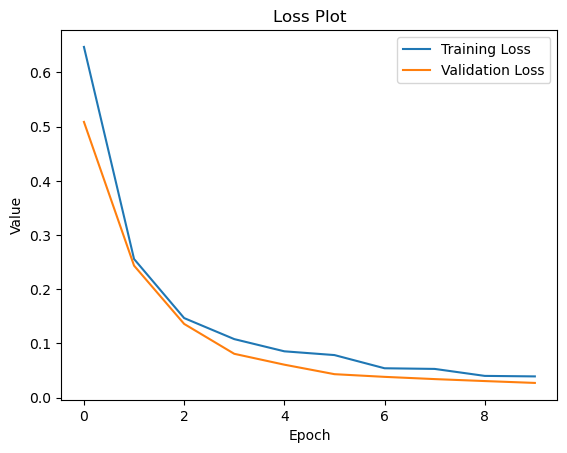

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

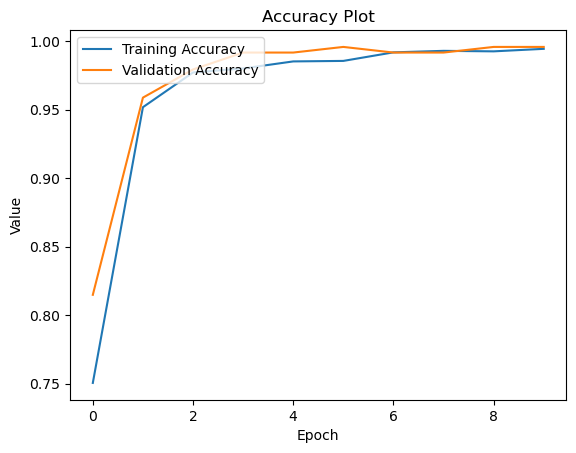

In [53]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Save Model

In [56]:
model.save('model_CNN_tanh_object.keras')

## Evaluasi Model

In [59]:
loss, acc = model.evaluate(train_data,steps=len(train_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.9989 
Loss on training data: 0.0145 

Accuracy on test data: 1.0000 
Loss on test data: 0.0313 



## Confusion Metriks

4/4 ━━━━━━━━━━━━━━━━━━━━ 103s 18s/step


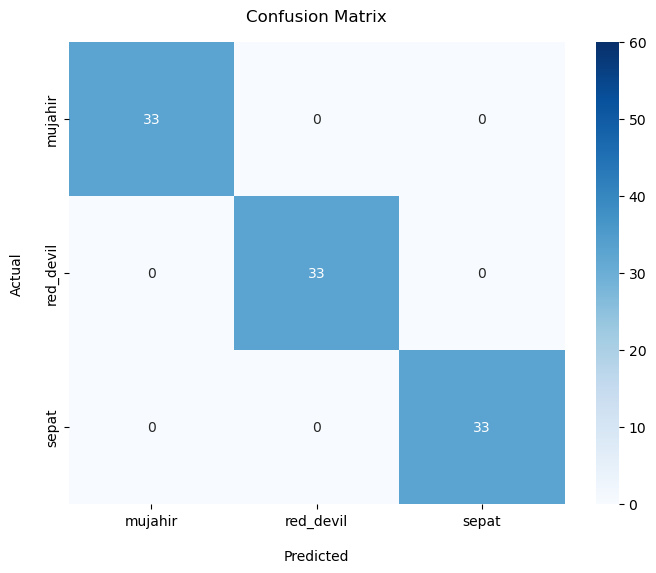

              precision    recall  f1-score   support

     mujahir       1.00      1.00      1.00        33
   red_devil       1.00      1.00      1.00        33
       sepat       1.00      1.00      1.00        33

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

checkpoint = load_model('model_CNN_tanh_object.keras')

predictions = checkpoint.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('Actual', labelpad=15)
plt.title('Confusion Matrix', pad=15)
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


misclassified_indices = np.where(true_classes != predicted_classes)[0]

for idx in misclassified_indices:

    img_path = train_generator.filepaths[idx]
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[predicted_classes[idx]]
    
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 119s 9s/step


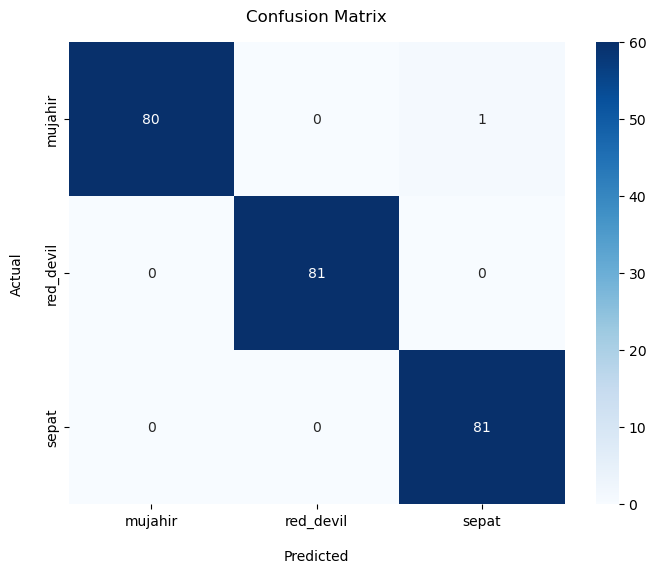

              precision    recall  f1-score   support

     mujahir       1.00      0.99      0.99        81
   red_devil       1.00      1.00      1.00        81
       sepat       0.99      1.00      0.99        81

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243



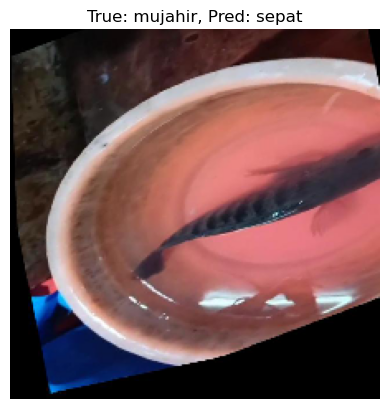

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

checkpoint = load_model('model_CNN_tanh_object.keras')

predictions = checkpoint.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('Actual', labelpad=15)
plt.title('Confusion Matrix', pad=15)
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


misclassified_indices = np.where(true_classes != predicted_classes)[0]

for idx in misclassified_indices:

    img_path = train_generator.filepaths[idx]
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[predicted_classes[idx]]
    
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()


Predictions for class: mujahir
Processing dataset/test/mujahir\1_mp4-0012_jpg.rf.af408cddf66ccba558575e67d654671a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step
Processing dataset/test/mujahir\3_mp4-0001_jpg.rf.78c9387cea52f16b363b97e29b2224b4.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
Processing dataset/test/mujahir\3_mp4-0007_jpg.rf.bad24d31e5fd7ac75000cc3bfa89e488.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Processing dataset/test/mujahir\3_mp4-0009_jpg.rf.7a6de95452636bd2a742b23d4faf81cd.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Processing dataset/test/mujahir\5_mp4-0015_jpg.rf.09ab1aaf6b49190b804d1e3d04cbcbc0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Processing dataset/test/mujahir\6_mp4-0000_jpg.rf.977683a3c9107b8fb33a5b971cbebd3b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Processing dataset/test/mujahir\6_mp4-0010_jpg.rf.0d2f29000f8d072d3f12176aa3aa6ef0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Processing dataset/test/mujahir\6_mp4-0013_jpg.rf.5e66c2d053fe7b14

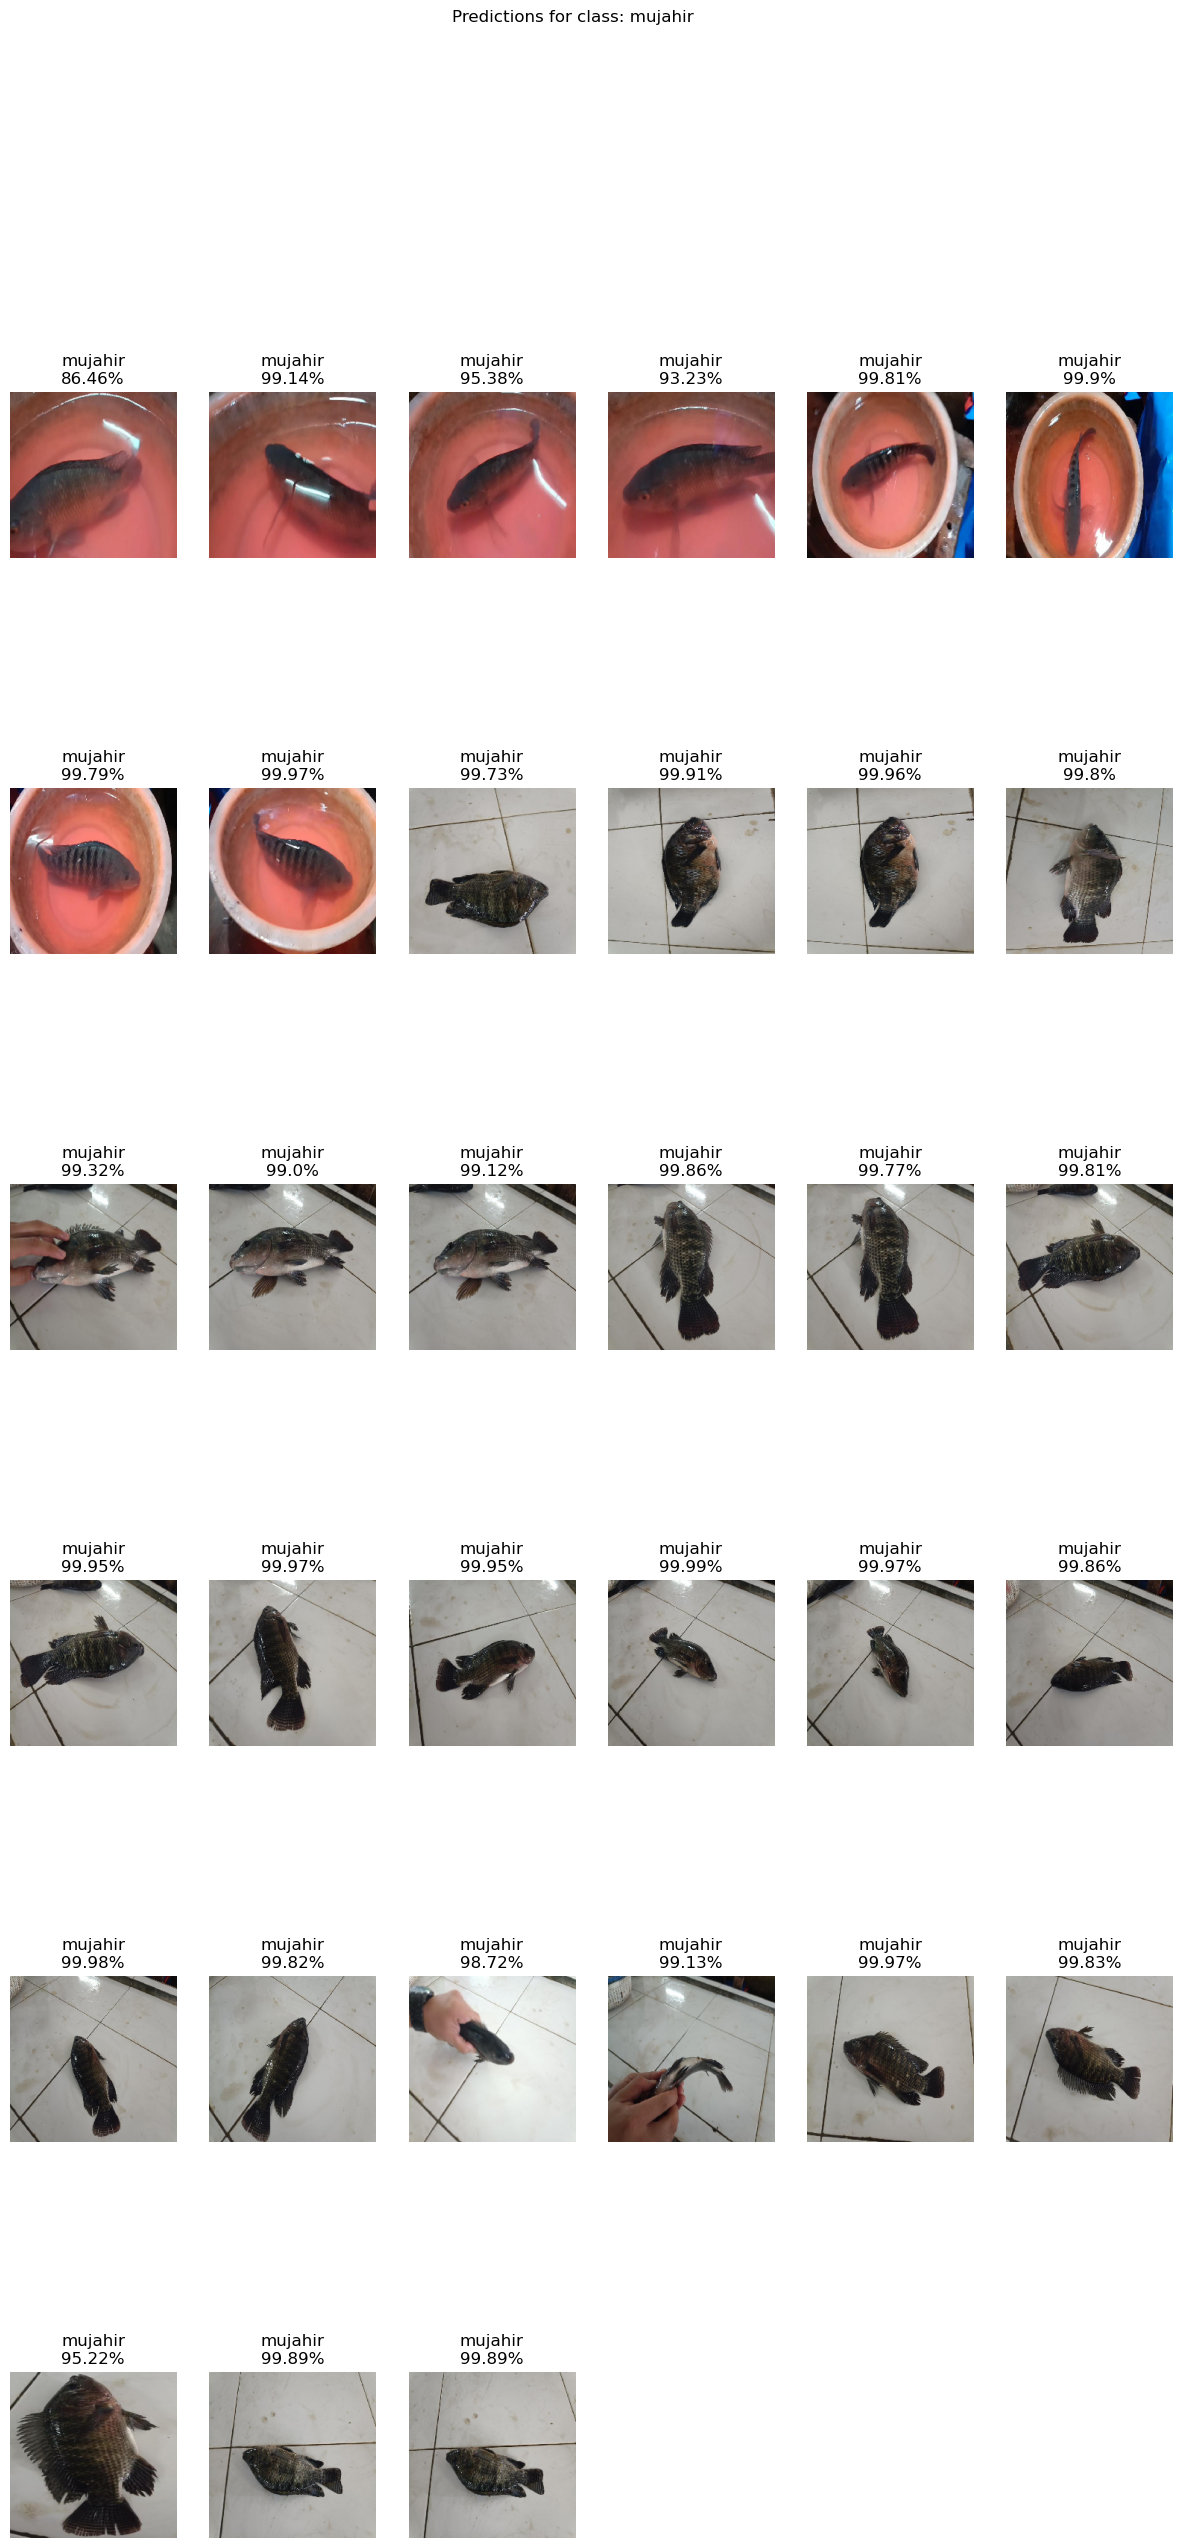


Predictions for class: red_devil
Processing dataset/test/red_devil\Red-Devil-101_png_jpg.rf.d9ed07b6e68c3e93176715b0010a3e33.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Processing dataset/test/red_devil\Red-Devil-104_png_jpg.rf.f98dbbec37a56d0a59d7e05f5344b89b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Processing dataset/test/red_devil\Red-Devil-105_png_jpg.rf.b1efa865a6a211728f411c07d75584a5.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
Processing dataset/test/red_devil\Red-Devil-109_png_jpg.rf.7d9224c65e66461b159bda0982f45d7f.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Processing dataset/test/red_devil\Red-Devil-122_png_jpg.rf.aa35b61ed0b16c3834001f5945a8fc38.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Processing dataset/test/red_devil\Red-Devil-132_png_jpg.rf.ae8fcd7bc96bbea6375168be5bcc857c.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Processing dataset/test/red_devil\Red-Devil-153-_jpg.rf.e300eec181f3255f1b7e705612f6c111.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Pro

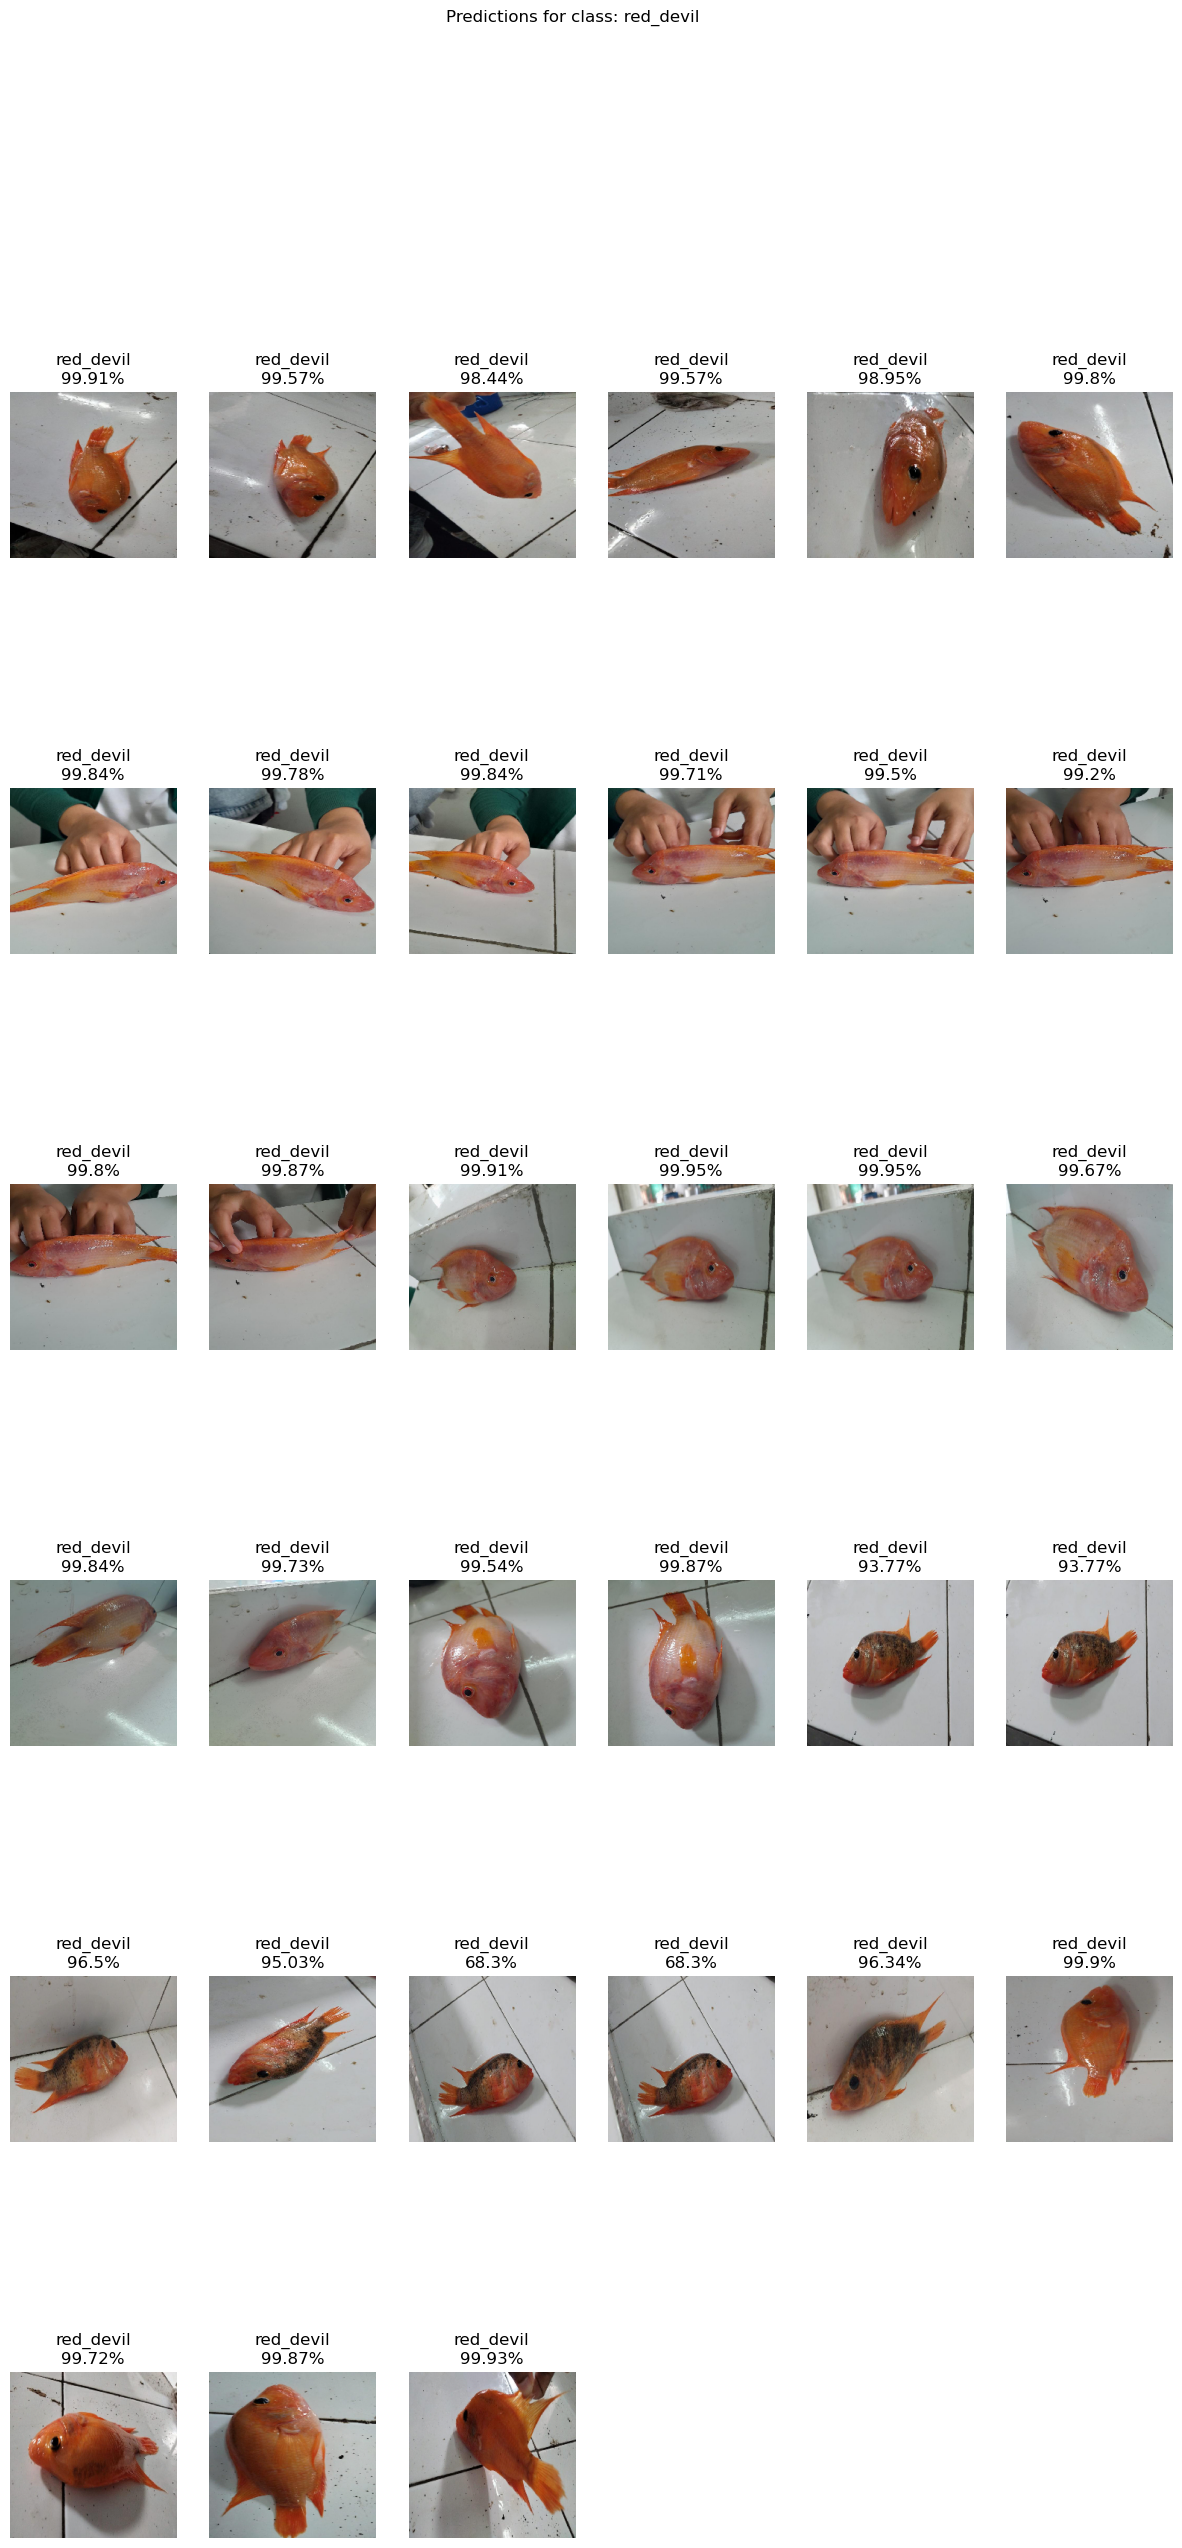


Predictions for class: sepat
Processing dataset/test/sepat\Sepat-104_png_jpg.rf.c8efe00703ee19d384763c8a05f1b4f6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Processing dataset/test/sepat\Sepat-105_png_jpg.rf.e07125ea47295be33fcbe35134c37fc6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Processing dataset/test/sepat\Sepat-115_png_jpg.rf.10ef20970ea1c9e1857d1192fa523831.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Processing dataset/test/sepat\Sepat-117_png_jpg.rf.dfe4e7f8212150cc64d5ddef0e09aaf1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Processing dataset/test/sepat\Sepat-15_png_jpg.rf.29fb2d9e7813596912e320f4e4017b8a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Processing dataset/test/sepat\Sepat-16_png_jpg.rf.eeed7dcbc9bb558bc6056c1e9964eb61.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Processing dataset/test/sepat\Sepat-176_jpg.rf.b6caed48284f4995afd08e63b1ee04ce.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Processing dataset/test/sepat\Sepat-184_jpg.rf.ccc8af4b661e42903d2

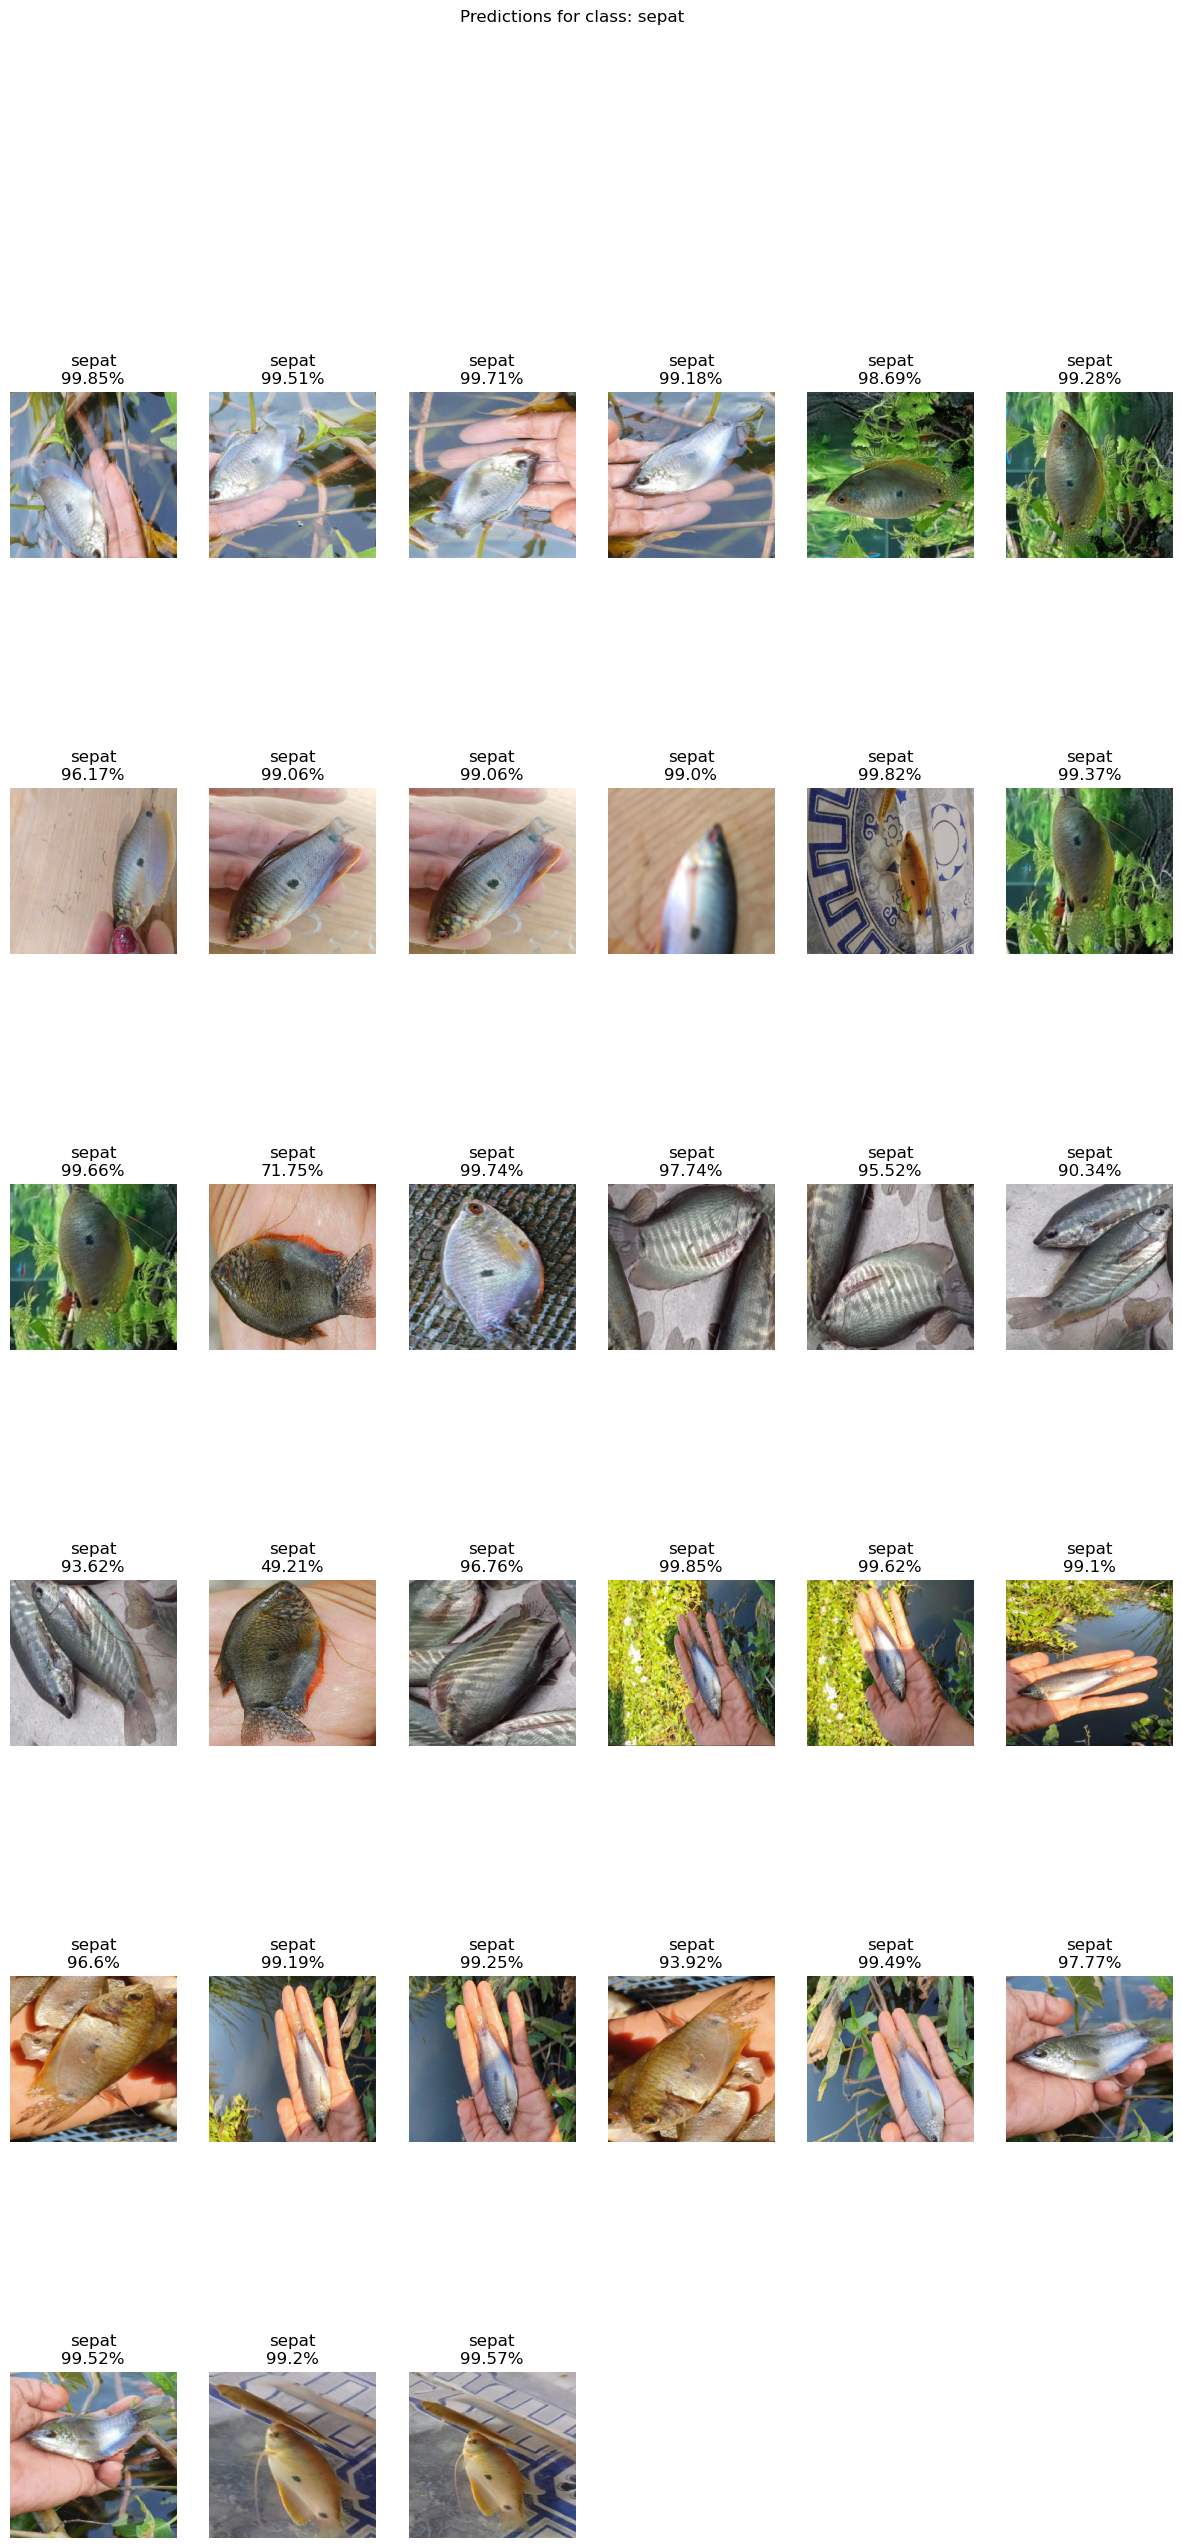

In [66]:
# Load model
model_path = 'model_CNN_tanh_object.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=IMG_SIZE)  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    return img, label, round(probability * 100, 2)

def predict_images_from_class(class_folder, model):
    images = []
    labels = []
    probabilities = []

    # Ambil semua gambar dari folder kelas tertentu
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            print(f"Processing {img_path}...")
            img, label, probability = predict_image(img_path, model)
            images.append(img)
            labels.append(label)
            probabilities.append(probability)

    return images, labels, probabilities

dataset_path = 'dataset/test/'

classes = ['mujahir', 'red_devil', 'sepat']

# Prediksi gambar dari setiap kelas
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    print(f"\nPredictions for class: {class_name}")
    images, labels, probabilities = predict_images_from_class(class_folder, loaded_model)
    max_images_per_row = 6
    num_rows = (len(images) + max_images_per_row - 1) // max_images_per_row 

    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(len(images)):
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"{labels[i]}\n{probabilities[i]}%")
    
    plt.suptitle(f"Predictions for class: {class_name}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


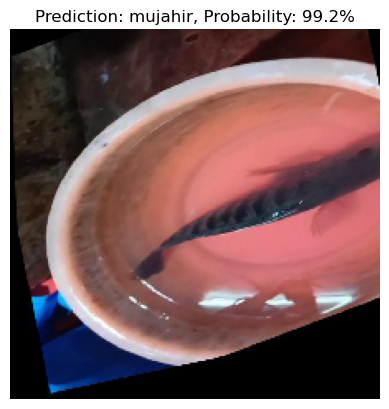

Label: mujahir
Probability: 99.2%


In [68]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE= (224, 224)

model_path = 'model_CNN_tanh_object.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    # Tampilkan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}, Probability: {round(probability * 100, 2)}%")
    plt.show()

    print(f"Label: {label}")
    print(f"Probability: {round(probability * 100, 2)}%")

# Path ke gambar

# img_path = 'new_data/Ikan-Sepat.jpg'
# img_path = 'new_data/ikan-red-devil-3137882226 .jpg'
# img_path = 'new_data/ikan-mujair1.jpg'
# img_path = 'new_data/6n (238).jpg'
# img_path = 'new_data/Red-devil2.jpg'
# img_path = 'new_data/devil.jpg'


# Prediksi gambar
predict_image(img_path, loaded_model)